In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

#### visualise the region in the raw data estimated by the coordinate estimators

In [3]:
EXPERIMENT_METRICS_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl"
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [4]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'target_metrics',
       'attributes', 'decoy_metrics'],
      dtype='object')

In [5]:
SEQUENCE_LIBRARY_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/sequence-library/sequence-library.pkl'
sequence_library_df = pd.read_pickle(SEQUENCE_LIBRARY_FILE_NAME)

In [6]:
selected_sequence = 'SELSQSEQQR'
selected_sequence_charge = 2

In [7]:
selected_sequence_in_library = sequence_library_df[(sequence_library_df.sequence == selected_sequence) & (sequence_library_df.charge == selected_sequence_charge)].iloc[0]

In [8]:
selected_sequence_in_library

sequence                         SELSQSEQQR
charge                                    2
theoretical_mz                      596.284
experiment_scan_mean                824.787
experiment_scan_std_dev             4.91522
experiment_scan_peak_width            37.65
experiment_rt_mean                   188.44
experiment_rt_std_dev               5.05329
experiment_rt_peak_width            21.1486
experiment_intensity_mean           59186.3
experiment_intensity_std_dev        17011.1
number_of_runs_identified                 5
q_value                         0.000111063
Name: 23134, dtype: object

In [9]:
# the runs of interest for comparison
run_name_A = '190719_Hela_Ecoli_1to1_01'
file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_02'
file_idx_B = file_idx_for_run(run_name_B)

In [10]:
# target coordinates in each run for the selected sequence
feature_coordinates_A = experiment_metrics_for_library_sequences_df[(experiment_metrics_for_library_sequences_df.sequence == selected_sequence) & (experiment_metrics_for_library_sequences_df.charge == selected_sequence_charge) & (experiment_metrics_for_library_sequences_df.file_idx == file_idx_A)].iloc[0].target_coords
feature_coordinates_B = experiment_metrics_for_library_sequences_df[(experiment_metrics_for_library_sequences_df.sequence == selected_sequence) & (experiment_metrics_for_library_sequences_df.charge == selected_sequence_charge) & (experiment_metrics_for_library_sequences_df.file_idx == file_idx_B)].iloc[0].target_coords


In [11]:
feature_coordinates_A

{'mono_mz': 596.2833580974396,
 'scan_apex': 824.7273698480615,
 'rt_apex': 204.26423838303728}

In [12]:
feature_coordinates_B

{'mono_mz': 596.2830728852343,
 'scan_apex': 823.7776788237609,
 'rt_apex': 194.09357591937126}

In [13]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8


In [14]:
NUMBER_OF_RT_APEX_FRAMES = 5
NUMBER_OF_STD_DEVS_CCS = 10
NUMBER_OF_DA_MZ_LEFT = 1
NUMBER_OF_DA_MZ_RIGHT = 7

In [15]:
# find the closest frame ids to the apex
frame_ids_dir = '~/Downloads/experiments/dwm-test/frames-subsets'
frame_ids_A_df = pd.read_pickle('{}/{}-frame-properties-df.pkl'.format(frame_ids_dir, run_name_A))
frame_ids_A_df = frame_ids_A_df[(frame_ids_A_df.MsMsType == FRAME_TYPE_MS1)][['Id','Time']]

frame_ids_B_df = pd.read_pickle('{}/{}-frame-properties-df.pkl'.format(frame_ids_dir, run_name_B))
frame_ids_B_df = frame_ids_B_df[(frame_ids_B_df.MsMsType == FRAME_TYPE_MS1)][['Id','Time']]


In [16]:
frame_ids_A_df['delta_rt'] = np.abs(frame_ids_A_df.Time - feature_coordinates_A['rt_apex'])
frame_ids_A_df.sort_values(by=['delta_rt'], inplace=True)
frame_ids_A_df.reset_index(drop=True, inplace=True)
print("frames to extract from {}: {}".format(run_name_A, ' '.join([str(v) for v in list(frame_ids_A_df.loc[0:NUMBER_OF_RT_APEX_FRAMES-1].Id)])))

frames to extract from 190719_Hela_Ecoli_1to1_01: 1924 1929 1919 1934 1914


In [17]:
frame_ids_B_df['delta_rt'] = np.abs(frame_ids_B_df.Time - feature_coordinates_B['rt_apex'])
frame_ids_B_df.sort_values(by=['delta_rt'], inplace=True)
frame_ids_B_df.reset_index(drop=True, inplace=True)
print("frames to extract from {}: {}".format(run_name_B, ' '.join([str(v) for v in list(frame_ids_B_df.loc[0:NUMBER_OF_RT_APEX_FRAMES-1].Id)])))

frames to extract from 190719_Hela_Ecoli_1to1_02: 1835 1830 1840 1825 1845


In [18]:
frames_subset_A_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_A))
scan_lower = feature_coordinates_A['scan_apex'] - (NUMBER_OF_STD_DEVS_CCS * selected_sequence_in_library.experiment_scan_std_dev)
scan_upper = feature_coordinates_A['scan_apex'] + (NUMBER_OF_STD_DEVS_CCS * selected_sequence_in_library.experiment_scan_std_dev)
mz_lower = feature_coordinates_A['mono_mz'] - NUMBER_OF_DA_MZ_LEFT
mz_upper = feature_coordinates_A['mono_mz'] + NUMBER_OF_DA_MZ_RIGHT
frames_subset_A_df = frames_subset_A_df[(frames_subset_A_df.scan >= scan_lower) & (frames_subset_A_df.scan <= scan_upper) & (frames_subset_A_df.mz >= mz_lower) & (frames_subset_A_df.mz <= mz_upper)]

frames_subset_B_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_B))
scan_lower = feature_coordinates_B['scan_apex'] - (NUMBER_OF_STD_DEVS_CCS * selected_sequence_in_library.experiment_scan_std_dev)
scan_upper = feature_coordinates_B['scan_apex'] + (NUMBER_OF_STD_DEVS_CCS * selected_sequence_in_library.experiment_scan_std_dev)
mz_lower = feature_coordinates_B['mono_mz'] - NUMBER_OF_DA_MZ_LEFT
mz_upper = feature_coordinates_B['mono_mz'] + NUMBER_OF_DA_MZ_RIGHT
frames_subset_B_df = frames_subset_B_df[(frames_subset_B_df.scan >= scan_lower) & (frames_subset_B_df.scan <= scan_upper) & (frames_subset_B_df.mz >= mz_lower) & (frames_subset_B_df.mz <= mz_upper)]


In [19]:
# Get the raw points for the monoisotopic peak (constrained by the fragmentation event)
MZ_TOLERANCE_PPM = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

mono_mz_ppm_tolerance_A = feature_coordinates_A['mono_mz'] * MZ_TOLERANCE_PERCENT / 100
mono_mz_lower_A = feature_coordinates_A['mono_mz'] - mono_mz_ppm_tolerance_A
mono_mz_upper_A = feature_coordinates_A['mono_mz'] + mono_mz_ppm_tolerance_A
mono_points_A = frames_subset_A_df[(frames_subset_A_df.mz >= mono_mz_lower_A) & (frames_subset_A_df.mz <= mono_mz_upper_A)]

mono_mz_ppm_tolerance_B = feature_coordinates_B['mono_mz'] * MZ_TOLERANCE_PERCENT / 100
mono_mz_lower_B = feature_coordinates_B['mono_mz'] - mono_mz_ppm_tolerance_B
mono_mz_upper_B = feature_coordinates_B['mono_mz'] + mono_mz_ppm_tolerance_B
mono_points_B = frames_subset_B_df[(frames_subset_B_df.mz >= mono_mz_lower_B) & (frames_subset_B_df.mz <= mono_mz_upper_B)]


In [20]:
frame_subset_intensity_max = max(frames_subset_A_df.intensity.max(), frames_subset_B_df.intensity.max())
mono_intensity_max = max(mono_points_A.intensity.max(), mono_points_B.intensity.max())


#### plots for comparing the selected sequence in run A and run B

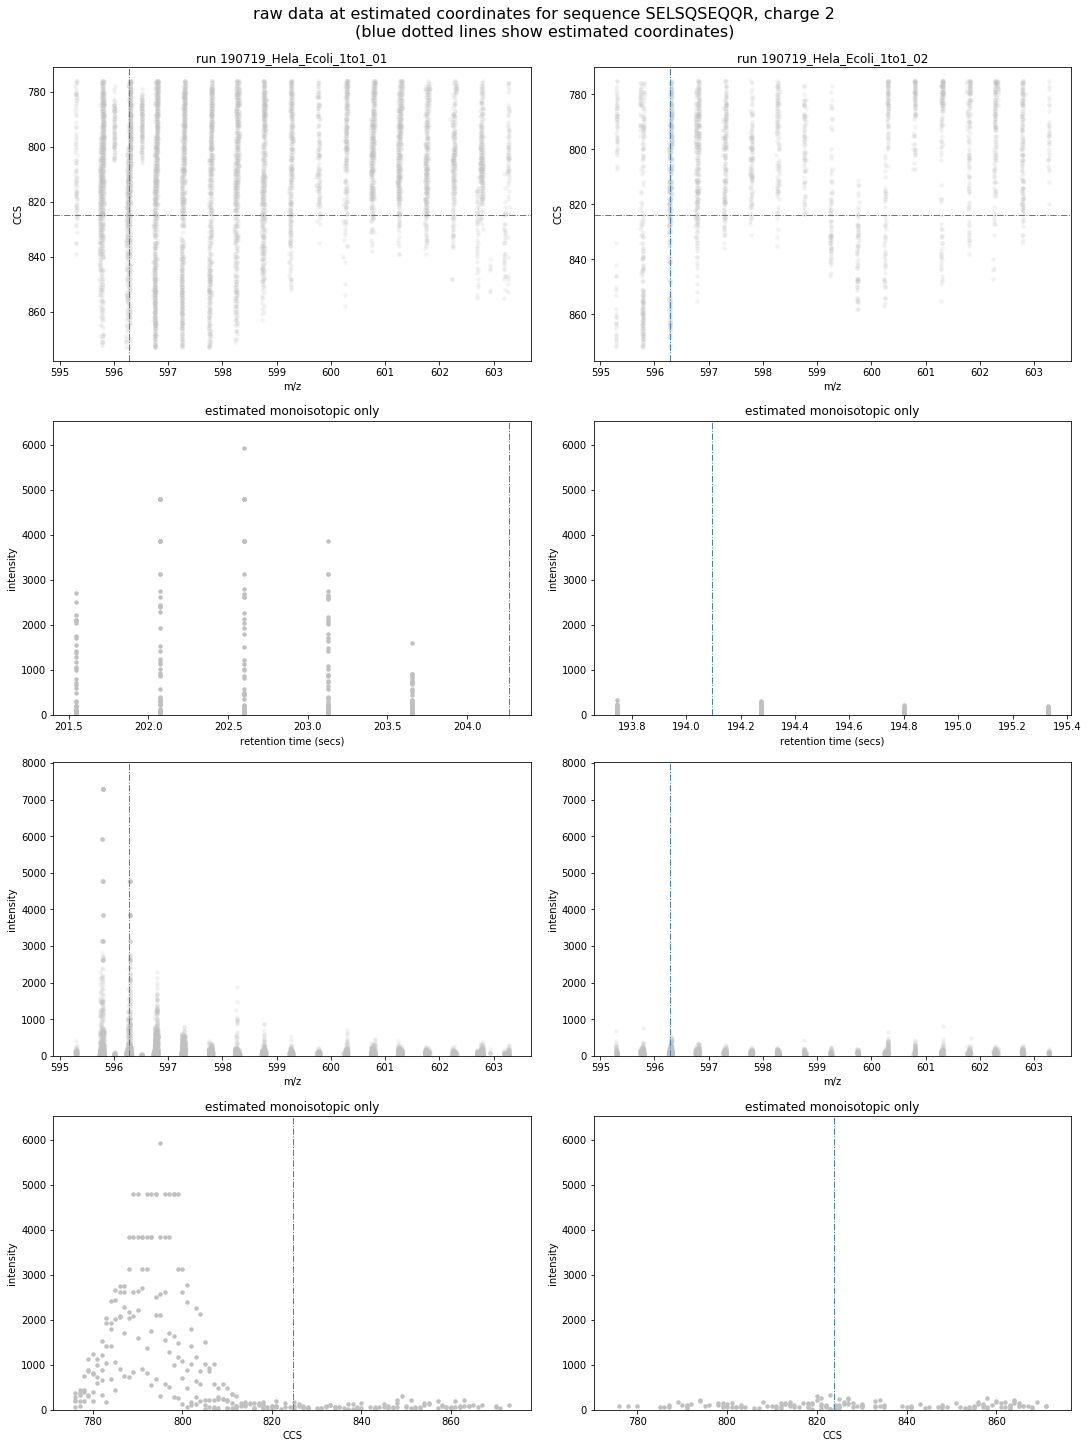

In [21]:
f, axarr = plt.subplots(nrows=4, ncols=2, constrained_layout=True)

f.set_figheight(20)
f.set_figwidth(15)
plt.margins(0.06)
f.suptitle('raw data at estimated coordinates for sequence {}, charge {}\n(blue dotted lines show estimated coordinates)'.format(selected_sequence, selected_sequence_charge), fontsize=16)

########
# run A - mz vs scan
########
ax = axarr[0,0]  # row, column
ax.set_title('run {}'.format(run_name_A))

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_A['mono_mz'], color='steelblue', lw=1.0, ls='-.')
ax.axhline(feature_coordinates_A['scan_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run A - RT vs intensity
########
ax = axarr[1,0]
ax.set_title('estimated monoisotopic only')

# plot the background points in the feature region
ax.scatter(mono_points_A.retention_time_secs, mono_points_A.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_A['rt_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,mono_intensity_max*1.1))
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run A - mz vs intensity
########
ax = axarr[2,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_A['mono_mz'], color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

########
# run A - CCS vs intensity
########
ax = axarr[3,0]
ax.set_title('estimated monoisotopic only')

# plot the background points in the feature region
ax.scatter(mono_points_A.scan, mono_points_A.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# draw the scan apex
ax.axvline(feature_coordinates_A['scan_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,mono_intensity_max*1.1))
ax.set_xlabel('CCS')
ax.set_ylabel('intensity')






########
# run B - mz vs scan
########
ax = axarr[0,1]
ax.set_title('run {}'.format(run_name_B))

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_B['mono_mz'], color='steelblue', lw=1.0, ls='-.')
ax.axhline(feature_coordinates_B['scan_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run B - RT vs intensity
########
ax = axarr[1,1]
ax.set_title('estimated monoisotopic only')

# plot the background points in the feature region
ax.scatter(mono_points_B.retention_time_secs, mono_points_B.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_B['rt_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,mono_intensity_max*1.1))
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run B - mz vs intensity
########
ax = axarr[2,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_B['mono_mz'], color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

########
# run B - CCS vs intensity
########
ax = axarr[3,1]
ax.set_title('estimated monoisotopic only')

# plot the background points in the feature region
ax.scatter(mono_points_B.scan, mono_points_B.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# draw the scan apex
ax.axvline(feature_coordinates_B['scan_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,mono_intensity_max*1.1))
ax.set_xlabel('CCS')
ax.set_ylabel('intensity')


plt.show()